In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from pathlib import Path
import cv2
import glob
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as process_mobileNetV3Large
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as process_efficientNetV2B0
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

train_path = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/train'
test_path  = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/test'
IMG_SHAPE = (256, 256, 3)
batch_size = 32
classData = 10

In [2]:
#data awal setelah dipisah secara manual. Data yang lebih dari 1000, telah dipisah secara manual
print('Dataset Training UnderSampling Balanced')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")


print('Dataset Testing UnderSampling Balanced')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

Dataset Training UnderSampling Balanced
303 	 bacterial_leaf_blight
303 	 bacterial_leaf_streak
303 	 bacterial_panicle_blight
303 	 blast
303 	 brown_spot
303 	 dead_heart
303 	 downy_mildew
303 	 hispa
303 	 normal
303 	 tungro
Dataset Testing UnderSampling Balanced
34 	 hispa
34 	 bacterial_panicle_blight
34 	 bacterial_leaf_blight
34 	 normal
34 	 downy_mildew
34 	 tungro
34 	 blast
34 	 bacterial_leaf_streak
34 	 brown_spot
34 	 dead_heart


In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(256,256),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=1
)

Found 3030 files belonging to 10 classes.
Using 2727 files for training.
Found 3030 files belonging to 10 classes.
Using 303 files for validation.
Found 340 files belonging to 10 classes.


In [4]:
#Ensemble Model Using Concatenation Method

model_MobileNetV3Large = MobileNetV3Large(
    include_top=False,
    alpha=1.0,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model_EfficientNetV2B0 = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

for layer in model_MobileNetV3Large.layers:
        layer.trainable = False


for layer in model_EfficientNetV2B0.layers:
        layer.trainable = False

models = [model_MobileNetV3Large, model_EfficientNetV2B0]
print(models)

24274472/24274472 [==============================] - 2s 0us/step
[<keras.engine.functional.Functional object at 0x7f3b584cbcd0>, <keras.engine.functional.Functional object at 0x7f3b58078ca0>]


In [5]:
inp = Input((256,256,3))

mobileNetV3Large_process = Lambda(process_mobileNetV3Large)(inp)
MobileNetV3Large = model_MobileNetV3Large(mobileNetV3Large_process)

efficientNetV2B0_process = Lambda(process_efficientNetV2B0)(inp)
EfficientNetV2B0 = model_EfficientNetV2B0(efficientNetV2B0_process)

x = Concatenate()([MobileNetV3Large, EfficientNetV2B0])
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(10, activation='softmax')(x) 

concatenation_ensemble_model = Model(inp, out)
concatenation_ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])  

In [6]:
#custom callback
class_names = train_ds.class_names
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = concatenation_ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
86/86 [==============================] - 138s 1s/step - loss: 2.0312 - accuracy: 0.5820 - val_loss: 0.6608 - val_accuracy: 0.8119
Epoch 2/10
86/86 [==============================] - 4s 39ms/step - loss: 0.1924 - accuracy: 0.9417 - val_loss: 0.5350 - val_accuracy: 0.8713
Epoch 3/10
86/86 [==============================] - 4s 39ms/step - loss: 0.0508 - accuracy: 0.9879 - val_loss: 0.5451 - val_accuracy: 0.8647
Epoch 4/10
86/86 [==============================] - 4s 38ms/step - loss: 0.0263 - accuracy: 0.9967 - val_loss: 0.4942 - val_accuracy: 0.8713
Epoch 5/10
86/86 [==============================] - 4s 38ms/step - loss: 0.0140 - accuracy: 0.9978 - val_loss: 0.5316 - val_accuracy: 0.8515
Epoch 6/10
86/86 [==============================] - 4s 39ms/step - loss: 0.0157 - accuracy: 0.9963 - val_loss: 0.6278 - val_accuracy: 0.8350
Epoch 7/10
86/86 [==============================] - 4s 38ms/step - loss: 0.0124 - accuracy: 0.9982 - val_loss: 0.5581 - val_accuracy: 0.8779


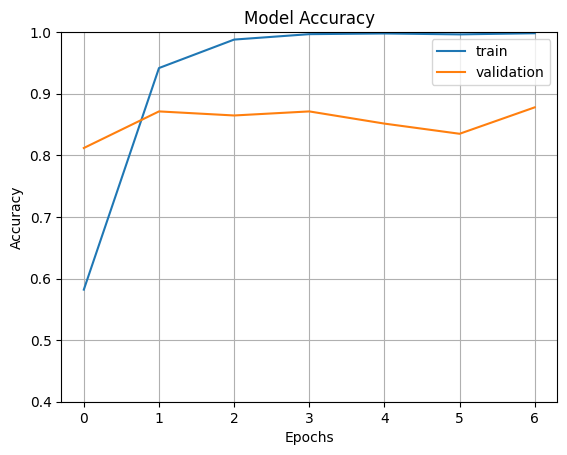

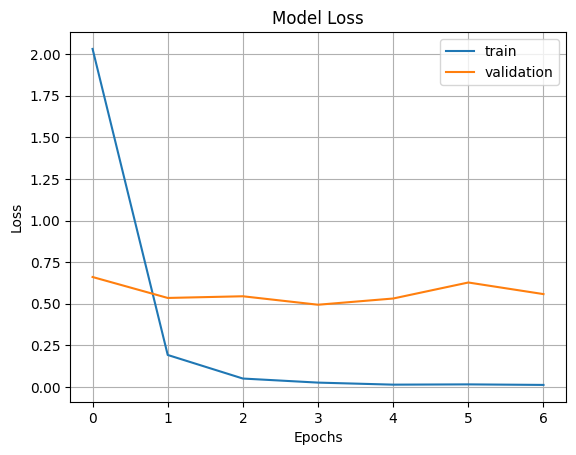

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import classification_report

#predict
predictions = concatenation_ensemble_model.predict(test_ds)

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

340/340 [==============================] - 16s 37ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.87      0.97      0.92        34
   bacterial_leaf_streak       0.83      1.00      0.91        34
bacterial_panicle_blight       0.97      0.97      0.97        34
                   blast       0.75      0.79      0.77        34
              brown_spot       0.92      0.65      0.76        34
              dead_heart       0.97      0.94      0.96        34
            downy_mildew       0.77      0.79      0.78        34
                   hispa       0.84      0.76      0.80        34
                  normal       0.79      0.91      0.85        34
                  tungro       0.90      0.76      0.83        34

                accuracy                           0.86       340
               macro avg       0.86      0.86      0.85       340
            weighted avg       0.86      0.86      0.85       340



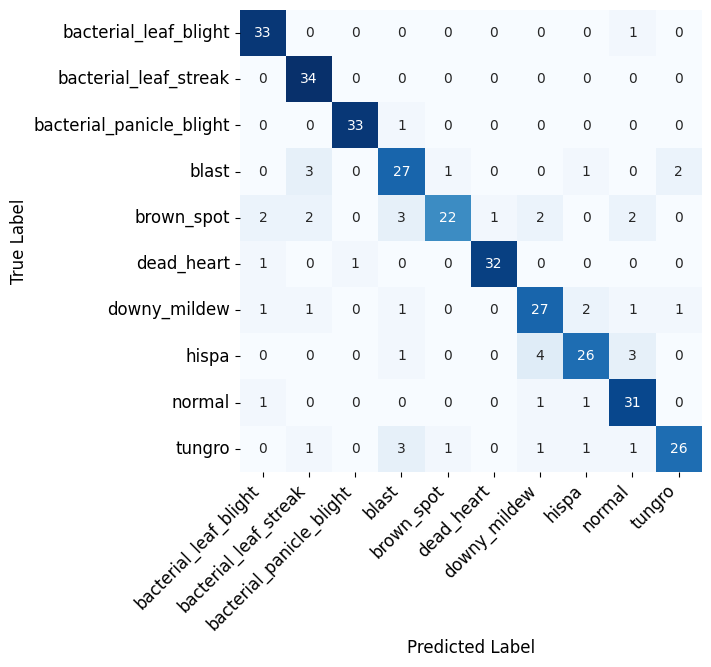

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="ConcatenationEnsemble-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [10]:
concatenation_ensemble_model.save('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EnsembleConcatenation_UnderSampling_256.h5')

In [60]:
train_path = '/content/drive/MyDrive/PaddyDisease/Aug_OverSampling_Dataset/train'
test_path  = '/content/drive/MyDrive/PaddyDisease/Aug_OverSampling_Dataset/test'

#data awal setelah dipisah secara manual. Data yang lebih dari 1000, telah dipisah secara manual
print('Dataset Training OverSampling Balanced')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")


print('Dataset Testing OverSampling Balanced')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

Dataset Training OverSampling Balanced
894 	 bacterial_leaf_blight
913 	 bacterial_leaf_streak
898 	 brown_spot
909 	 blast
891 	 bacterial_panicle_blight
910 	 dead_heart
895 	 downy_mildew
907 	 normal
900 	 hispa
900 	 tungro
Dataset Testing OverSampling Balanced
100 	 brown_spot
100 	 blast
100 	 hispa
100 	 bacterial_leaf_blight
100 	 tungro
99 	 bacterial_panicle_blight
100 	 bacterial_leaf_streak
100 	 downy_mildew
100 	 normal
100 	 dead_heart


In [61]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(256,256),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=1
)

Found 9017 files belonging to 10 classes.
Using 8116 files for training.
Found 9017 files belonging to 10 classes.
Using 901 files for validation.
Found 999 files belonging to 10 classes.


In [62]:
#Ensemble Model Using Concatenation Method
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2B0

model_MobileNetV3Large = MobileNetV3Large(
    include_top=False,
    alpha=1.0,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model_EfficientNetV2B0 = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

for layer in model_MobileNetV3Large.layers:
        layer.trainable = False


for layer in model_EfficientNetV2B0.layers:
        layer.trainable = False

models = [model_MobileNetV3Large, model_EfficientNetV2B0]
print(models)

[<keras.engine.functional.Functional object at 0x7f3a96530fd0>, <keras.engine.functional.Functional object at 0x7f3880d1a9a0>]


In [63]:
inp = Input((256,256,3))

mobileNetV3Large_process = Lambda(process_mobileNetV3Large)(inp)
MobileNetV3Large = model_MobileNetV3Large(mobileNetV3Large_process)

efficientNetV2B0_process = Lambda(process_efficientNetV2B0)(inp)
EfficientNetV2B0 = model_EfficientNetV2B0(efficientNetV2B0_process)

x = Concatenate()([MobileNetV3Large, EfficientNetV2B0])
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(10, activation='softmax')(x) 

concatenation_ensemble_model = Model(inp, out)
concatenation_ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])  

In [64]:
#custom callback
class_names = train_ds.class_names
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = concatenation_ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
254/254 [==============================] - 24s 46ms/step - loss: 1.1695 - accuracy: 0.7117 - val_loss: 0.4917 - val_accuracy: 0.8590
Epoch 2/10
254/254 [==============================] - 9s 36ms/step - loss: 0.1681 - accuracy: 0.9506 - val_loss: 0.4263 - val_accuracy: 0.8968
Epoch 3/10
254/254 [==============================] - 9s 36ms/step - loss: 0.0869 - accuracy: 0.9779 - val_loss: 0.3763 - val_accuracy: 0.9101
Epoch 4/10
254/254 [==============================] - 9s 36ms/step - loss: 0.0567 - accuracy: 0.9864 - val_loss: 0.4272 - val_accuracy: 0.8968
Epoch 5/10
254/254 [==============================] - 9s 36ms/step - loss: 0.0556 - accuracy: 0.9853 - val_loss: 0.5526 - val_accuracy: 0.8868
Epoch 6/10
254/254 [==============================] - 9s 36ms/step - loss: 0.0553 - accuracy: 0.9847 - val_loss: 0.5632 - val_accuracy: 0.8979


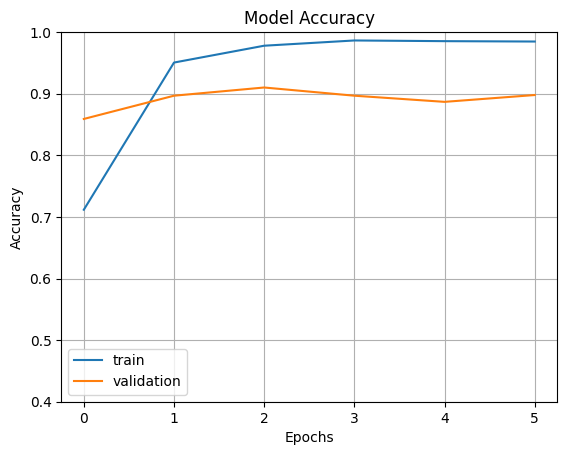

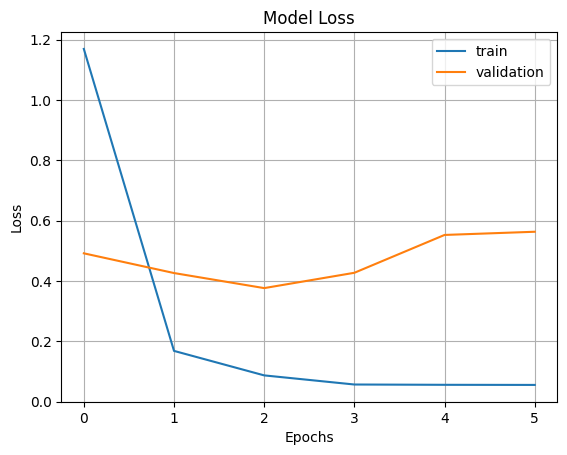

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [66]:
import numpy as np
from sklearn.metrics import classification_report

#predict
predictions = concatenation_ensemble_model.predict(test_ds)

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

999/999 [==============================] - 16s 13ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.89      0.80      0.84       100
   bacterial_leaf_streak       0.88      0.98      0.92       100
bacterial_panicle_blight       0.99      0.95      0.97        99
                   blast       0.87      0.90      0.89       100
              brown_spot       0.98      0.82      0.89       100
              dead_heart       0.98      0.94      0.96       100
            downy_mildew       0.85      0.88      0.87       100
                   hispa       0.81      0.91      0.86       100
                  normal       0.80      0.95      0.87       100
                  tungro       0.93      0.79      0.85       100

                accuracy                           0.89       999
               macro avg       0.90      0.89      0.89       999
            weighted avg       0.90      0.89      0.89       999



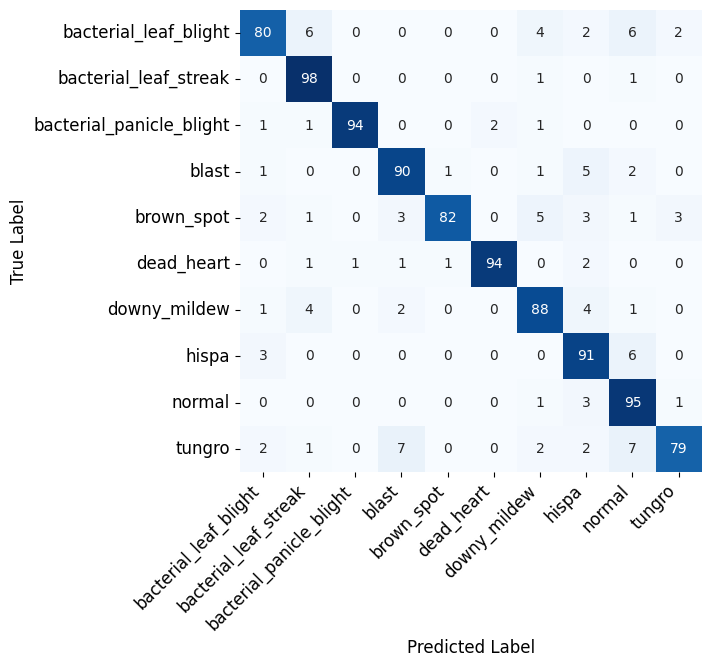

In [67]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="ConcatenationEnsemble-OverSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [68]:
concatenation_ensemble_model.save('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EnsembleConcatenation_OverSampling_256.h5')